<a href="https://colab.research.google.com/github/sunlaito/LearnPennyLane/blob/main/Basic4_Backpropagation_and_parameter_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ref: https://pennylane.ai/qml/demos/tutorial_backprop.html

In [ ]:
!pip install pennylane --upgrade

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [ ]:
# set the random seed
np.random.seed(42)

# initial parameters
params = np.random.random([6])

print("Parameters:", params)
print("Expectation value:", circuit(params))
print(circuit.draw())

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871569
 0: ──RX(0.375)──╭C─────────────────╭X──RX(0.599)──╭C──────╭X──╭┤ ⟨Y ⊗ Z⟩ 
 1: ──RY(0.951)──╰X──╭C──RY(0.156)──│──────────────╰X──╭C──│───│┤         
 2: ──RZ(0.732)──────╰X─────────────╰C──RZ(0.156)──────╰X──╰C──╰┤ ⟨Y ⊗ Z⟩ 



In [ ]:
# PennyLane’s built-in parameter-shift feature
# Note that when we define the QNode, we set the argument as diff_method="parameter-shift"
# Note the effects of setting argnum
grad_function = qml.grad(circuit, argnum=0)
grad_function_test = qml.grad(circuit)

print(grad_function(params))
print(grad_function_test(params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]
(array([-6.51887722e-02, -2.72891905e-02,  0.00000000e+00, -9.33934621e-02,
       -7.61067572e-01,  8.32667268e-17]),)


In [ ]:
# Realizing the parameter-shift feature manully
def parameter_shift_term(qnode, params, i):
    shifted = params.copy() # shallow copy of params, avoiding the modification of shifted affects params
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.0651887722495813


In [ ]:
# loop over all elements of params
def parameter_shift(qnode, params):
    gradients = np.zeros(len(params))

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]


In [ ]:
# Benchmarking on a larger circuit
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", mutable=False)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [ ]:
# Note that we specify that the QNode is immutable. 
# This is more restrictive than a standard mutable QNode (the quantum circuit cannot change/differ between executions); 
# however, it reduces processing overhead.

In [ ]:
# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
print(params.size)
print(circuit(params))

180
0.8947771876917632


In [ ]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps) 
# globals=globals(), the optional globals argument specifies a namespace in which to execute the code
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.011549214999996593 sec per loop


In [ ]:
# create the gradient function
grad_fn = qml.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 4.306805283599999 sec per loop


In [ ]:
# the parameter-shift method, which requires 2*p circuit evaluations for p parameters
print(forward_time * 2 * params.size)

4.1577173999987735


In [ ]:
# Backpropagation

In [ ]:
import tensorflow as tf

In [ ]:
dev = qml.device("default.qubit.tf", wires=4)

# By default, diff_method="backprop" for the default.qubit.tf device when interface="tf"
@qml.qnode(dev, diff_method="backprop", interface="tf")
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=15)
paramstf = tf.Variable(params) # convert params to a tf varible, otherwise circuit gradient cannot be calculated using tf  

print(circuit(params))
print(circuit(paramstf))

tf.Tensor([0.95375887], shape=(1,), dtype=float64)
tf.Tensor([0.95375887], shape=(1,), dtype=float64)


In [ ]:
print(type(params))
print(type(paramstf))

<class 'pennylane.numpy.tensor.tensor'>
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [ ]:
import timeit

reps = 3
num = 10
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.13757916829999886 sec per loop


In [ ]:
# tf.GradientTape is used to calculate the differentiation of res with respect to paramstf 
with tf.GradientTape(persistent=True) as tape:
    res = circuit(paramstf)

times = timeit.repeat("tape.gradient(res, paramstf)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num
print(f"Backward pass (best of {reps}): {backward_time} sec per loop")

Backward pass (best of 3): 0.17922987830002057 sec per loop


In [ ]:
# For backprop, the time taken to perform the backwards pass appears of the order of a single forward pass

# In reverse-mode autodifferentiation, the gradient can be computed with the same degree of complexity as the original function, 
# regardless of the number of parameters (albeit with some additional memory overhead).

In [ ]:
# Time comparison

In [ ]:
dev_shift = qml.device("default.qubit", wires=4)
dev_backprop = qml.device("default.qubit.tf", wires=4)

def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [ ]:
reps = 2
num = 3

forward_shift = []
gradient_shift = []
forward_backprop = []
gradient_backprop = []

for depth in range(0, 21):
    params = qml.init.strong_ent_layers_normal(n_wires=4, n_layers=depth)
    num_params = params.size
    params = tf.Variable(params)

    # forward pass timing
    # ===================

# interface is the interface that will be used for classical backpropagation. 
# interface affects the types of objects that can be passed to/returned from the QNode

    qnode_shift = qml.QNode(circuit, dev_shift, interface="tf", mutable=False, diff_method="parameter-shift")
    # by default, diff_method="best"
    qnode_backprop = qml.QNode(circuit, dev_backprop, interface="tf")

    # parameter-shift
    t = timeit.repeat("qnode_shift(params)", globals=globals(), number=num, repeat=reps)
    forward_shift.append([num_params, min(t) / num])

    # backprop
    t = timeit.repeat("qnode_backprop(params)", globals=globals(), number=num, repeat=reps)
    forward_backprop.append([num_params, min(t) / num])

    if num_params == 0:
        continue

    # Gradient timing
    # ===============

    qnode_shift = qml.QNode(circuit, dev_shift, interface="tf", mutable=False, diff_method="parameter-shift")
    qnode_backprop = qml.QNode(circuit, dev_backprop, interface="tf")

    # parameter-shift
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_shift(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_shift.append([num_params, min(t) / num])

    # backprop
    with tf.GradientTape(persistent=True) as tape:
        res = qnode_backprop(params)

    t = timeit.repeat("tape.gradient(res, params)", globals=globals(), number=num, repeat=reps)
    gradient_backprop.append([num_params, min(t) / num])

gradient_shift = np.array(gradient_shift).T
gradient_backprop = np.array(gradient_backprop).T
forward_shift = np.array(forward_shift).T
forward_backprop = np.array(forward_backprop).T

In [ ]:
print(gradient_shift)

[[1.20000000e+01 2.40000000e+01 3.60000000e+01 4.80000000e+01
  6.00000000e+01 7.20000000e+01 8.40000000e+01 9.60000000e+01
  1.08000000e+02 1.20000000e+02 1.32000000e+02 1.44000000e+02
  1.56000000e+02 1.68000000e+02 1.80000000e+02 1.92000000e+02
  2.04000000e+02 2.16000000e+02 2.28000000e+02 2.40000000e+02]
 [3.24079020e-02 1.02107334e-01 2.02036411e-01 3.50637113e-01
  5.28991250e-01 7.40073816e-01 1.00685659e+00 1.28933213e+00
  1.60044694e+00 1.96834366e+00 2.39185698e+00 2.84925379e+00
  3.24813931e+00 3.67198287e+00 4.32181798e+00 4.81260541e+00
  5.34894575e+00 6.04452444e+00 6.63271408e+00 7.29027735e+00]]


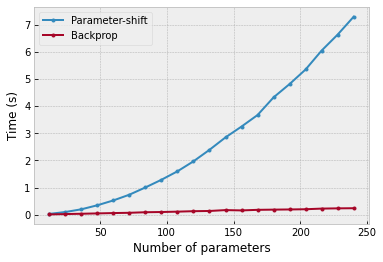

In [ ]:
# Plot the results
from matplotlib import pyplot as plt
plt.style.use("bmh")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of parameters")
ax.legend()

plt.show()

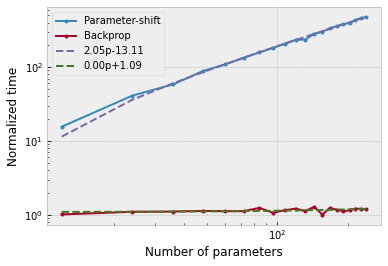

In [ ]:
gradient_shift[1] /= forward_shift[1, 1:]
gradient_backprop[1] /= forward_backprop[1, 1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(*gradient_shift, '.-', label="Parameter-shift")
ax.plot(*gradient_backprop, '.-', label="Backprop")

# perform a least squares regression to determine the linear best fit/gradient
# for the normalized time vs. number of parameters
x = gradient_shift[0]
m_shift, c_shift = np.polyfit(*gradient_shift, deg=1)
m_back, c_back = np.polyfit(*gradient_backprop, deg=1)

ax.plot(x, m_shift * x + c_shift, '--', label=f"{m_shift:.2f}p{c_shift:+.2f}")
ax.plot(x, m_back * x + c_back, '--', label=f"{m_back:.2f}p{c_back:+.2f}")

ax.set_ylabel("Normalized time")
ax.set_xlabel("Number of parameters")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()